# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [6]:
# Load in the test pickle file:

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [8]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [9]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [10]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [11]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [12]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [13]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [15]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $65.22 Truth: $65.99 Error: $0.77 SLE: 0.00 Item: Setpower Insulated Protective Cover for ...
2: Guess: $177.95 Truth: $9.68 Error: $168.27 SLE: 7.95 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $150.24 Truth: $155.98 Error: $5.74 SLE: 0.00 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $41.83 Truth: $5.59 Error: $36.24 SLE: 3.50 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $97.81 Truth: $98.40 Error: $0.59 SLE: 0.00 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $53.07 Truth: $54.99 Error: $1.92 SLE: 0.00 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $53.34 Truth: $5.71 Error: $47.63 SLE: 4.38 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $30.38 Truth: $9.53 Error: $20.85 SLE: 1.19 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $19.76 Truth: $11.24 Error: $8.52 SLE: 0.28 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $36.12 Truth: $12.88 Error: $23.24 SLE: 0.97 Item: Away NV350

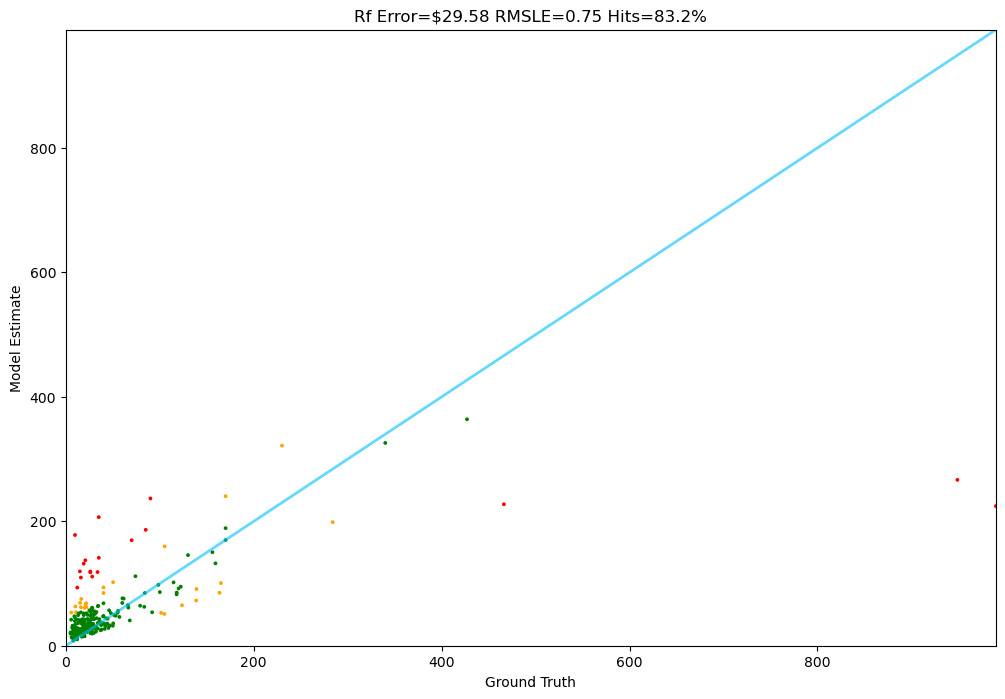

In [16]:
Tester.test(rf, test)

In [17]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [18]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

100.0
99.99
130.64319999999995


In [19]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [09:43<00:00,  2.33s/it]


In [20]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [21]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: -0.18
Frontier: 0.60
RandomForest: 0.04
Min: 0.61
Max: 0.15
Intercept=-1.20


In [22]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [23]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [24]:
ensemble.price(product)

125.18971590858268

In [25]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $57.86 Truth: $65.99 Error: $8.13 SLE: 0.02 Item: Setpower Insulated Protective Cover for ...
2: Guess: $41.28 Truth: $9.68 Error: $31.60 SLE: 1.89 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $140.85 Truth: $155.98 Error: $15.13 SLE: 0.01 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $14.28 Truth: $5.59 Error: $8.69 SLE: 0.71 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $57.53 Truth: $98.40 Error: $40.87 SLE: 0.28 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $30.82 Truth: $54.99 Error: $24.17 SLE: 0.32 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $20.63 Truth: $5.71 Error: $14.92 SLE: 1.37 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $12.00 Truth: $9.53 Error: $2.47 SLE: 0.04 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $14.29 Truth: $11.24 Error: $3.05 SLE: 0.05 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $22.23 Truth: $12.88 Error: $9.35 SLE: 0.27 Item: Away NV350 N

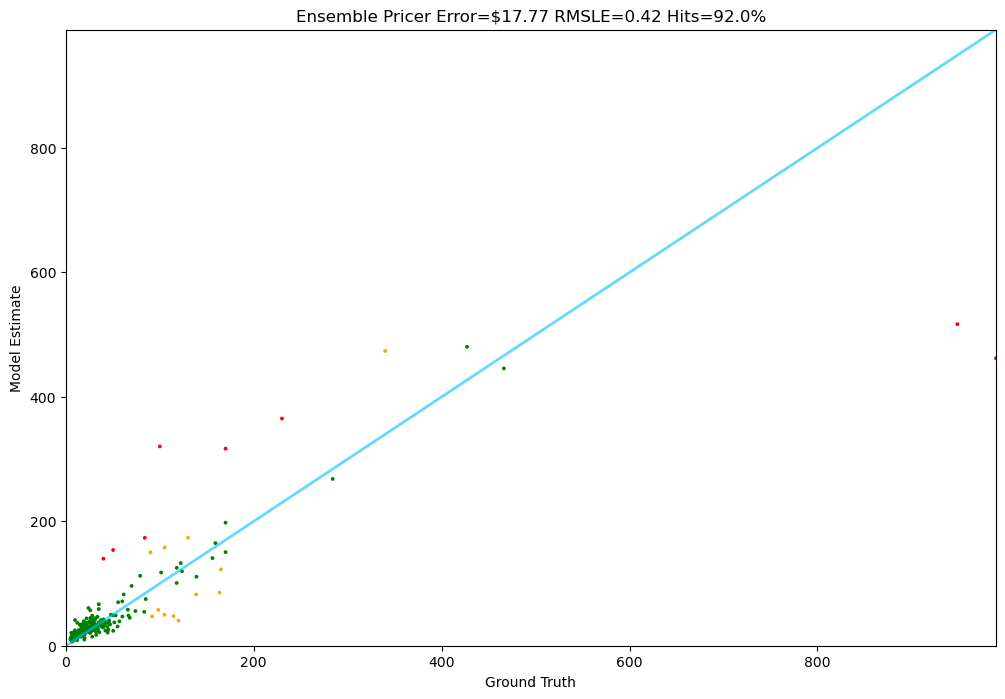

In [26]:
Tester.test(ensemble_pricer, test)

# WHAT A DAY!

We got so much done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.

You can do better, for sure!

Tweak this, and try adding components into the ensemble, to beat my performance.